In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report,roc_auc_score,RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

#importing the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# importing stats models library
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install lux

In [3]:
# import lux

In [4]:
df = pd.read_excel('/content/drive/MyDrive/placementProject/Banking_Call_Data.xlsx')

In [5]:
df.shape

(45211, 17)

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [9]:
df['y'].value_counts()

,count
y,
no,39922
yes,5289


In [ ]:
# The target column shows some imbalance need to rebalance it later on

In [10]:
# distributing the data into numeric and categorical columns
object_cols = []
numeric_cols = []
for i in df.columns:
  if df[i].dtype == 'object':
    object_cols.append(i)
  else:
    numeric_cols.append(i)

In [11]:
print('object columns: ', object_cols)

print('numeric columns: ',numeric_cols)

object columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
numeric columns:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [12]:
# Suspecting potential skewness in the dataset
def kde(cols):
  for col in cols:
    sns.kdeplot(data = df[col],fill = True)
    plt.show()

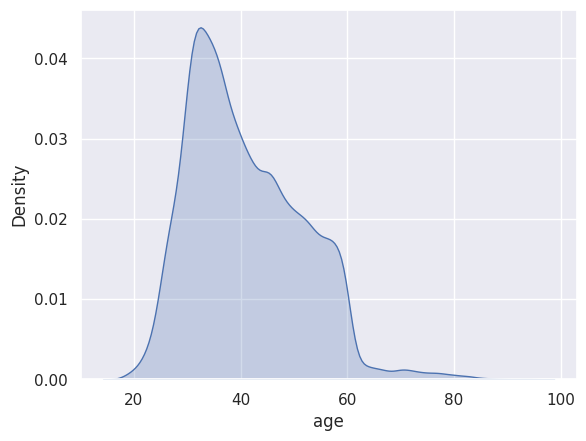

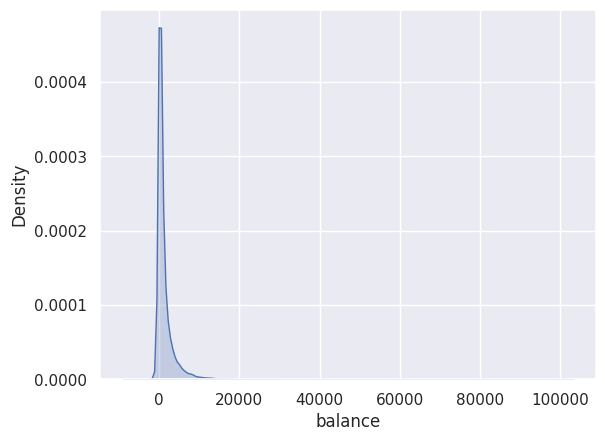

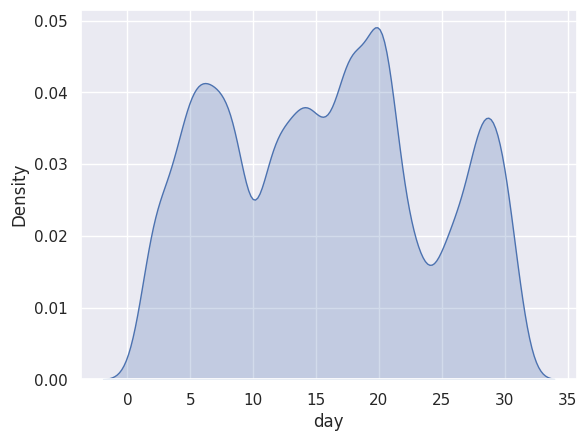

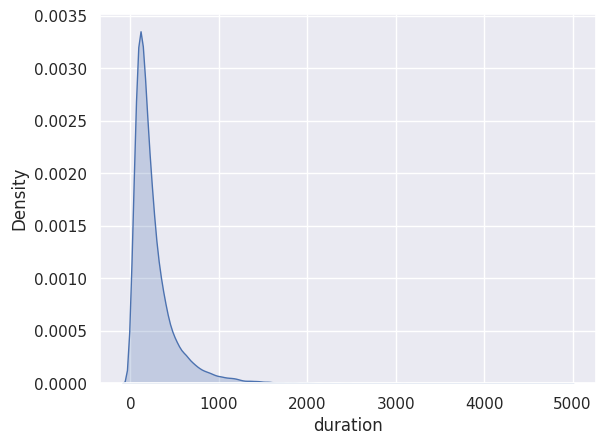

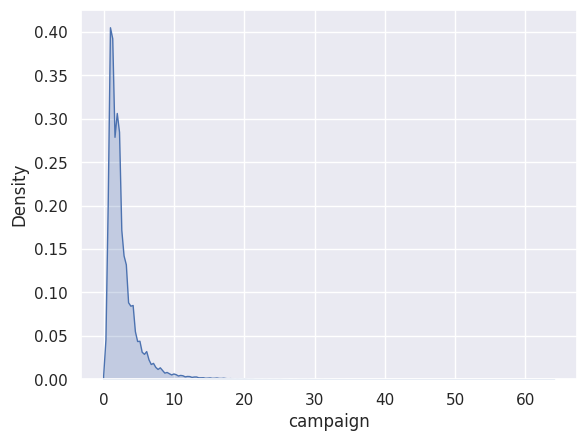

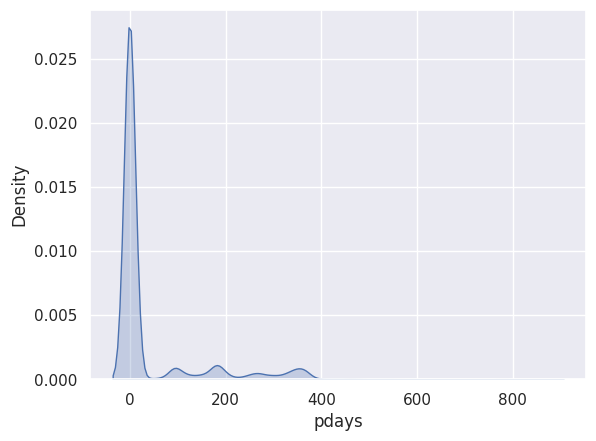

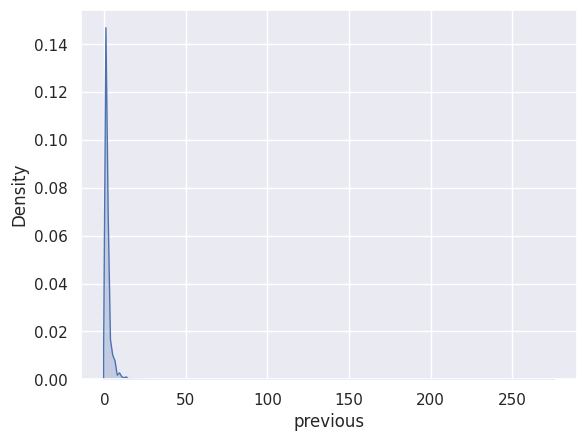

In [13]:
kde(numeric_cols)

In [14]:
# Outlier check
def boxplt(cols):
  for col in cols:
    sns.boxplot(data = df, x = col, fill  = True)
    plt.show()

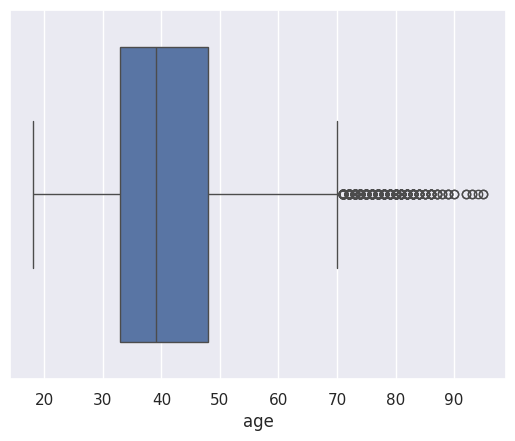

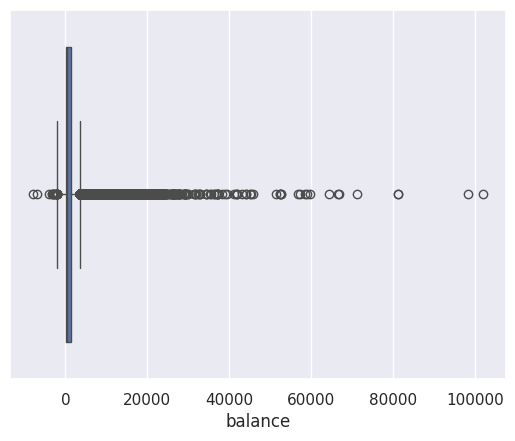

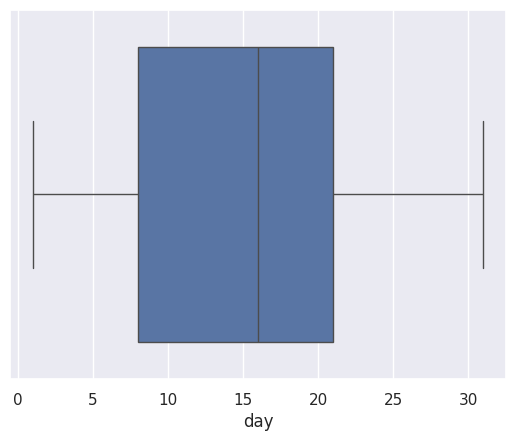

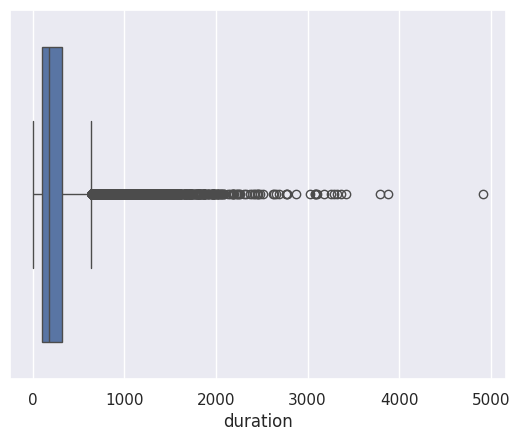

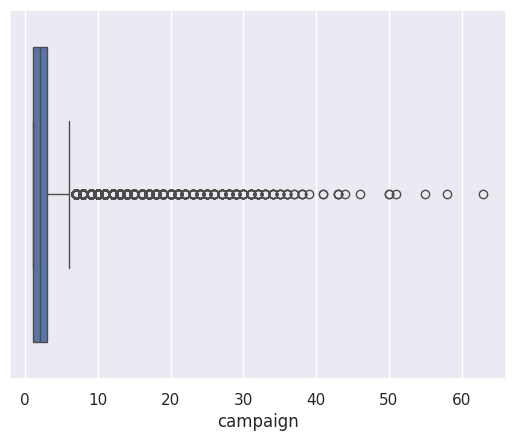

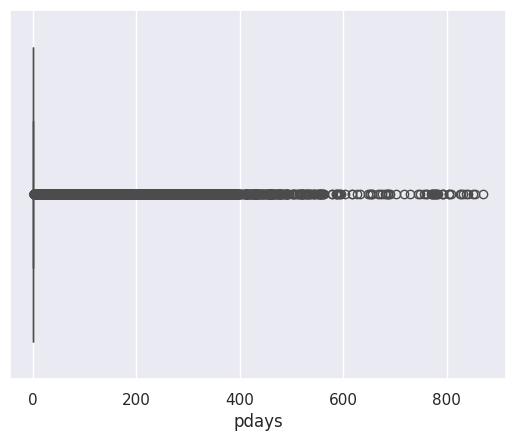

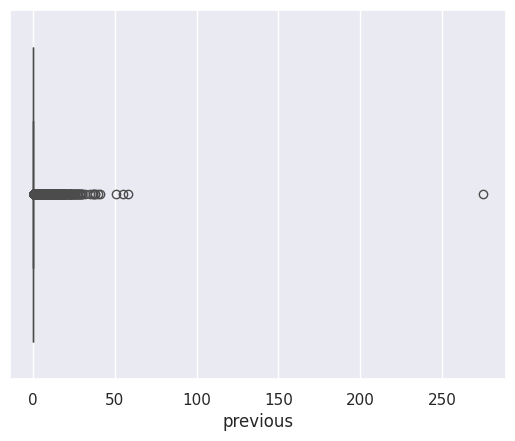

In [15]:
boxplt(numeric_cols)

In [16]:
# Unique Value counts check
for col in df.columns:
  print(col, ' : ',df[col].nunique())

age  :  77
job  :  12
marital  :  3
education  :  4
default  :  2
balance  :  7168
housing  :  2
loan  :  2
contact  :  3
day  :  31
month  :  12
duration  :  1573
campaign  :  48
pdays  :  559
previous  :  41
poutcome  :  4
y  :  2


In [17]:
# Unique value check
for col in df.columns:
  if df[col].nunique() < 10:
    print(col, ' : ',df[col].unique())

marital  :  ['married' 'single' 'divorced']
education  :  ['tertiary' 'secondary' 'unknown' 'primary']
default  :  ['no' 'yes']
housing  :  ['yes' 'no']
loan  :  ['no' 'yes']
contact  :  ['unknown' 'cellular' 'telephone']
poutcome  :  ['unknown' 'failure' 'other' 'success']
y  :  ['no' 'yes']


In [18]:
df['education'].mode()

,education
0,secondary


In [19]:
df['contact'].mode()

,contact
0,cellular


In [20]:
df['education'].value_counts()

,count
education,
secondary,23202
tertiary,13301
primary,6851
unknown,1857


In [21]:
df['poutcome'].value_counts()

,count
poutcome,
unknown,36959
failure,4901
other,1840
success,1511


In [22]:
df2 = df['education'].replace('unknown',np.nan)
df2

,education
0,tertiary
1,secondary
2,secondary
3,NaN
4,NaN
...,...
45206,tertiary
45207,primary
45208,secondary
45209,secondary


In [23]:
# Replacing the 'unknown' datapoints with mode values since it is a categorical data
def nanrplc(df):
  for i in df.columns:
    if 'unknown' in df[i].unique():
      df[i].replace('unknown',df[i].mode()[0],inplace = True)

In [24]:
df['education'].mode()[0]

'secondary'

In [25]:
df['poutcome'].mode()

,poutcome
0,unknown


In [26]:
nanrplc(df)

In [27]:
for col in df.columns:
  if df[col].nunique() < 10:
    print(col, ' : ',df[col].unique())

marital  :  ['married' 'single' 'divorced']
education  :  ['tertiary' 'secondary' 'primary']
default  :  ['no' 'yes']
housing  :  ['yes' 'no']
loan  :  ['no' 'yes']
contact  :  ['cellular' 'telephone']
poutcome  :  ['unknown' 'failure' 'other' 'success']
y  :  ['no' 'yes']


In [29]:
# Putting the Ordinal and Nominal columns separately
category1 = []
category2 = []
category3 = []
for col in df.columns:
  if df[col].dtype == 'O':
    if df[col].nunique() < 3:
      category1.append(col)
    elif col == 'education' or col == 'month':
      category3.append(col)
    else:
      category2.append(col)

In [30]:
category1

['default', 'housing', 'loan', 'contact', 'y']

In [31]:
category2

['job', 'marital', 'poutcome']

In [32]:
category3

['education', 'month']

In [33]:
category1.remove('y')

In [34]:
for col in category2:
  category1.append(col)

In [35]:
category1

['default', 'housing', 'loan', 'contact', 'job', 'marital', 'poutcome']

In [36]:
for col in category1:
  print(col, ' : ',df[col].unique())

default  :  ['no' 'yes']
housing  :  ['yes' 'no']
loan  :  ['no' 'yes']
contact  :  ['cellular' 'telephone']
job  :  ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital  :  ['married' 'single' 'divorced']
poutcome  :  ['unknown' 'failure' 'other' 'success']


##Encoding the Data

In [39]:
# One hot encoding of nominal data
enc1 = OneHotEncoder(sparse_output = False, drop = 'first')
enc2 = LabelEncoder()
df1 = enc1.fit_transform(df[category1])

In [40]:
df1 = pd.DataFrame(df1,columns = enc1.get_feature_names_out())

In [41]:
df1

,default_yes,housing_yes,loan_yes,contact_telephone,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,poutcome_unknown
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45209,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [42]:
# label ecoding for ordinal data
df2 = enc2.fit_transform(df['education'])
df3 = enc2.fit_transform(df['month'])

In [43]:
df2 = pd.DataFrame(df2,columns = ['education'])
df3 = pd.DataFrame(df3, columns = ['month'])

In [44]:
df2

,education
0,2
1,1
2,1
3,1
4,1
...,...
45206,2
45207,0
45208,1
45209,1


In [45]:
df3

,month
0,8
1,8
2,8
3,8
4,8
...,...
45206,9
45207,9
45208,9
45209,9


In [46]:
# Manual one hot encoding for the target column
df_target = df['y']
for y in df_target:
  if y == 'yes':
    df_target.replace('yes',1,inplace = True)
  else:
    df_target.replace('no',0,inplace = True)


In [47]:
df_target

,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


In [48]:
df1 = pd.concat([df1,df2,df3,df_target],axis = 1)

In [49]:
df_encoded = pd.concat([df[numeric_cols],df1],axis = 1)

In [50]:
df_encoded

,age,balance,day,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,...,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,poutcome_unknown,education,month,y
0,58,2143,5,261,1,-1,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,8,0
1,44,29,5,151,1,-1,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,8,0
2,33,2,5,76,1,-1,0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,8,0
3,47,1506,5,92,1,-1,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,8,0
4,33,1,5,198,1,-1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2,9,1
45207,71,1729,17,456,2,-1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,9,1
45208,72,5715,17,1127,5,184,3,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,9,1
45209,57,668,17,508,4,-1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,9,0


In [51]:
# Analyzing the important features
df_encoded.corr()

,age,balance,day,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,...,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,poutcome_unknown,education,month,y
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,-0.017879,-0.185513,-0.015655,...,-0.068632,0.000412,0.286257,-0.427817,-0.022967,0.035526,-0.000816,-0.164888,-0.042357,0.025155
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,-0.066745,-0.068768,-0.084350,...,-0.016183,0.009023,0.025708,-0.012537,0.008466,0.035240,-0.030271,0.067184,0.019777,0.052838
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,0.009424,-0.027982,0.011370,...,0.032517,-0.006382,0.007102,-0.007412,-0.032952,-0.030321,0.086256,0.025931,-0.006028,-0.028348
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,-0.010021,0.005075,-0.012412,...,-0.009176,0.020322,-0.022683,0.020328,-0.001958,0.042389,-0.003491,0.002635,0.006314,0.394521
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,0.016822,-0.023599,0.009980,...,0.020739,-0.018448,0.031371,-0.023120,-0.020107,-0.057486,0.107965,0.003703,-0.110031,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,-0.029979,0.124178,-0.022754,...,-0.013478,-0.010411,-0.027600,0.027943,0.389791,0.228539,-0.869962,0.004264,0.033065,0.103621
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,-0.018329,0.037076,-0.011043,...,-0.001123,-0.008504,-0.012691,0.017006,0.306615,0.201424,-0.532763,0.025175,0.022727,0.093236
default_yes,-0.017879,-0.066745,0.009424,-0.010021,0.016822,-0.029979,-0.018329,1.000000,-0.006025,0.077234,...,-0.003089,0.006470,-0.014460,0.003115,-0.014445,-0.023344,0.039490,-0.011539,0.011486,-0.022419
housing_yes,-0.185513,-0.068768,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.006025,1.000000,0.041323,...,-0.012823,-0.048229,0.017681,-0.020475,0.039710,-0.091360,-0.063755,-0.075157,0.271481,-0.139173
loan_yes,-0.015655,-0.084350,0.011370,-0.012412,0.009980,-0.022754,-0.011043,0.077234,0.041323,1.000000,...,0.014798,-0.035961,0.036906,-0.051716,-0.009099,-0.053713,0.031406,-0.025282,0.022145,-0.068185


In [52]:
df_encoded[numeric_cols].nunique()

,0
age,77
balance,7168
day,31
duration,1573
campaign,48
pdays,559
previous,41


In [54]:
df_encoded.corr()

,age,balance,day,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,...,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,poutcome_unknown,education,month,y
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,-0.017879,-0.185513,-0.015655,...,-0.068632,0.000412,0.286257,-0.427817,-0.022967,0.035526,-0.000816,-0.164888,-0.042357,0.025155
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,-0.066745,-0.068768,-0.084350,...,-0.016183,0.009023,0.025708,-0.012537,0.008466,0.035240,-0.030271,0.067184,0.019777,0.052838
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,0.009424,-0.027982,0.011370,...,0.032517,-0.006382,0.007102,-0.007412,-0.032952,-0.030321,0.086256,0.025931,-0.006028,-0.028348
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,-0.010021,0.005075,-0.012412,...,-0.009176,0.020322,-0.022683,0.020328,-0.001958,0.042389,-0.003491,0.002635,0.006314,0.394521
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,0.016822,-0.023599,0.009980,...,0.020739,-0.018448,0.031371,-0.023120,-0.020107,-0.057486,0.107965,0.003703,-0.110031,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,-0.029979,0.124178,-0.022754,...,-0.013478,-0.010411,-0.027600,0.027943,0.389791,0.228539,-0.869962,0.004264,0.033065,0.103621
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,-0.018329,0.037076,-0.011043,...,-0.001123,-0.008504,-0.012691,0.017006,0.306615,0.201424,-0.532763,0.025175,0.022727,0.093236
default_yes,-0.017879,-0.066745,0.009424,-0.010021,0.016822,-0.029979,-0.018329,1.000000,-0.006025,0.077234,...,-0.003089,0.006470,-0.014460,0.003115,-0.014445,-0.023344,0.039490,-0.011539,0.011486,-0.022419
housing_yes,-0.185513,-0.068768,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.006025,1.000000,0.041323,...,-0.012823,-0.048229,0.017681,-0.020475,0.039710,-0.091360,-0.063755,-0.075157,0.271481,-0.139173
loan_yes,-0.015655,-0.084350,0.011370,-0.012412,0.009980,-0.022754,-0.011043,0.077234,0.041323,1.000000,...,0.014798,-0.035961,0.036906,-0.051716,-0.009099,-0.053713,0.031406,-0.025282,0.022145,-0.068185


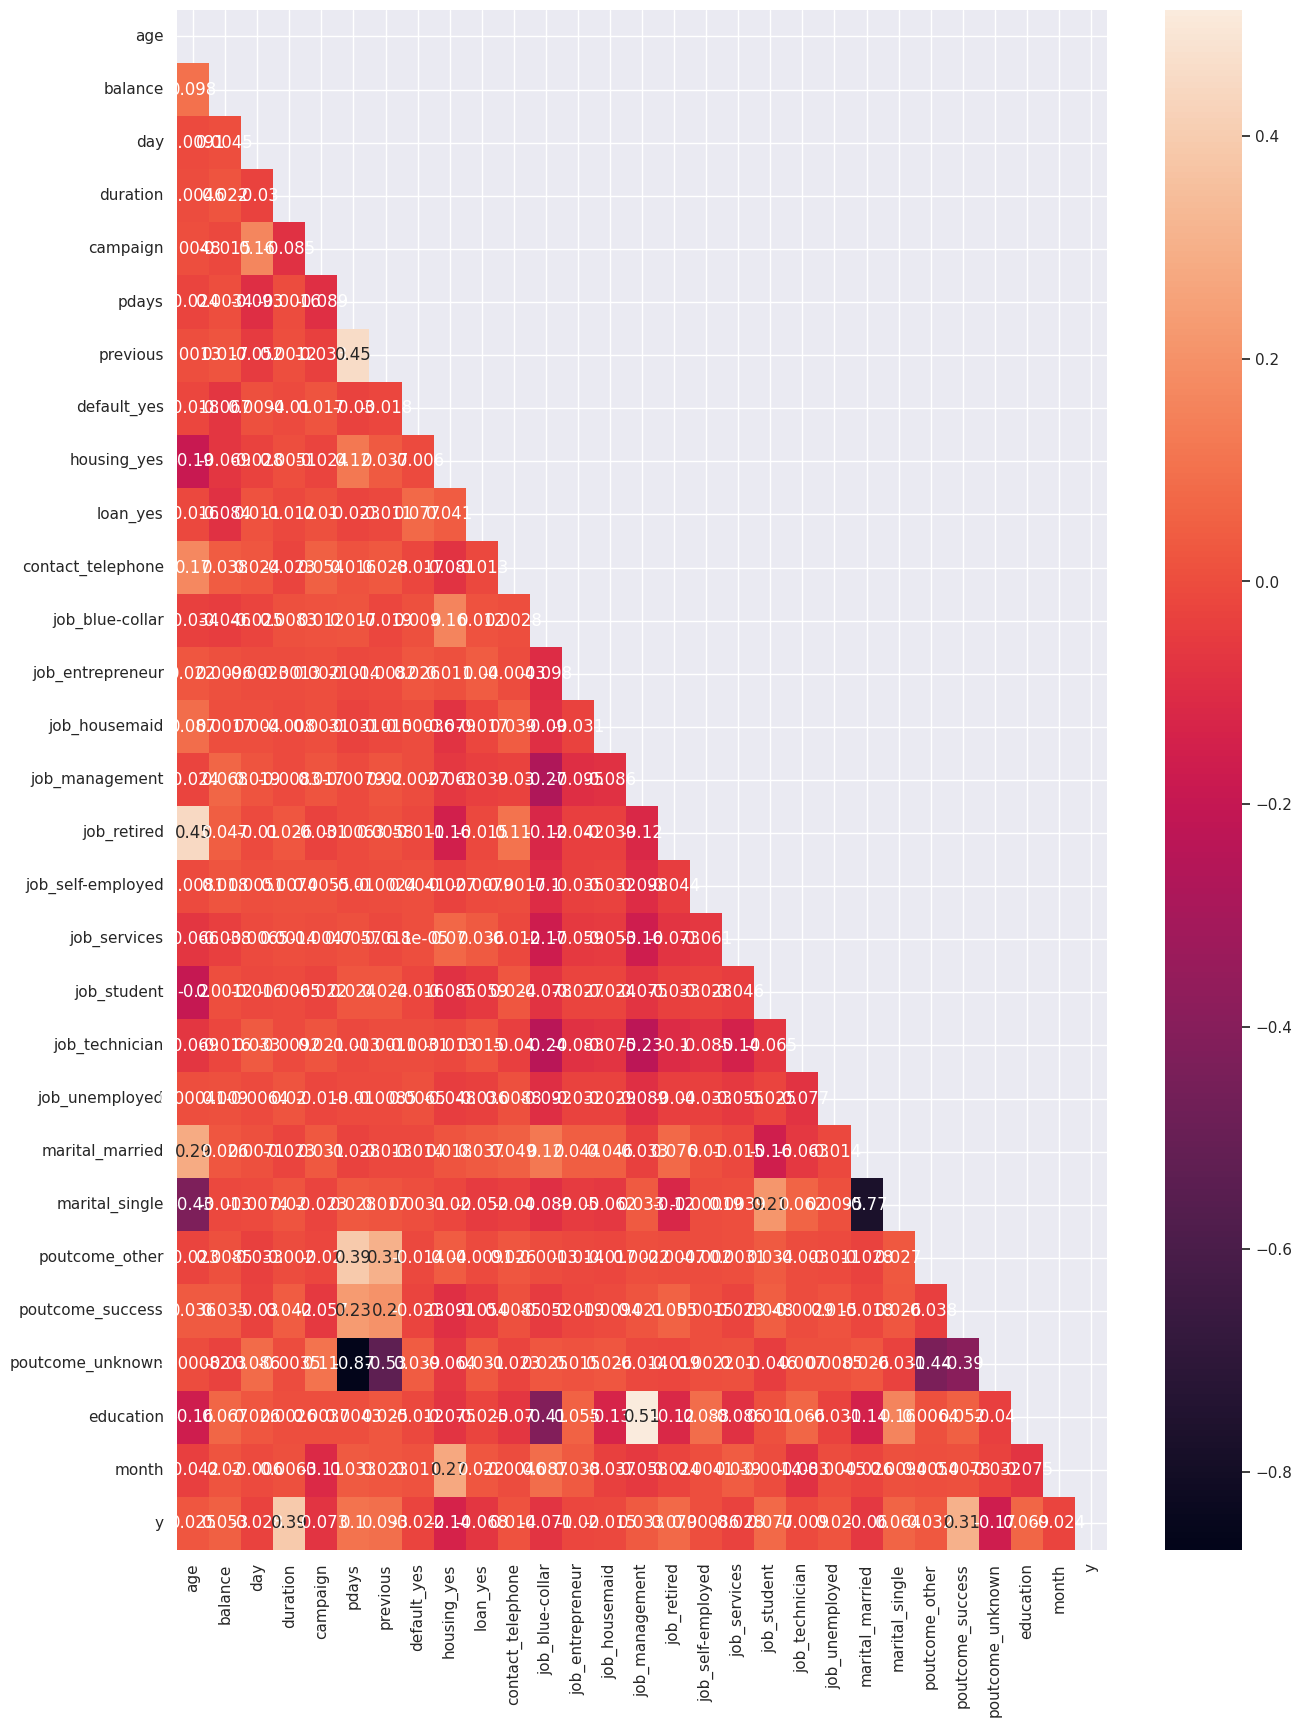

In [55]:
plt.figure(figsize = (15,20))
sns.heatmap(df_encoded.corr(), mask = np.triu(df_encoded.corr()),annot = True)
plt.show()

In [56]:
df_encoded['y'].value_counts(normalize = True)*100

,proportion
y,
0,88.30152
1,11.69848


## Traditional ML Model building


In [57]:
x = df_encoded.iloc[:,:-1]
y=df_encoded['y']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 42, stratify = y)

In [58]:
scaler = StandardScaler()
numeric_cols_to_scale = ['age','duration','campaign','pdays','previous','balance','day']
x_train[numeric_cols_to_scale] = scaler.fit_transform(x_train[numeric_cols_to_scale])
x_test[numeric_cols_to_scale] = scaler.fit_transform(x_test[numeric_cols_to_scale])

In [59]:
x_train

,age,balance,day,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,...,job_student,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,poutcome_unknown,education,month
24001,-0.460434,-0.164410,1.582124,-0.457311,-0.246104,-0.410910,-0.241509,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
43409,-1.589641,0.899627,-1.298384,2.502493,0.398202,1.446096,2.664584,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
20669,0.292371,-0.365486,-0.458236,5.697691,0.398202,-0.410910,-0.241509,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1
18810,0.668773,-0.445003,1.822166,-0.862499,2.653271,-0.410910,-0.241509,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,5
23130,-0.272233,-0.361249,1.222060,-0.777602,2.331118,-0.410910,-0.241509,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,0.856974,-0.146160,1.702145,-0.773743,-0.246104,-0.410910,-0.241509,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,5
15941,-0.460434,-0.437834,0.741975,-0.700423,0.720354,-0.410910,-0.241509,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,5
16952,0.386471,-0.419258,1.102039,-0.619386,-0.568256,-0.410910,-0.241509,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,5
34781,-1.307339,0.388954,-1.178363,-0.121583,-0.568256,-0.410910,-0.241509,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2,8


In [60]:
x_test.head()

,age,balance,day,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,...,job_student,job_technician,job_unemployed,marital_married,marital_single,poutcome_other,poutcome_success,poutcome_unknown,education,month
1392,-0.104787,-0.240657,-0.936754,0.359466,-0.248415,-0.413631,-0.315367,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,8
7518,0.273153,-0.329539,1.718905,-0.214327,-0.248415,-0.413631,-0.315367,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,8
12007,-0.955152,-0.337003,0.511787,-0.114710,0.727721,-0.413631,-0.315367,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,6
5536,-0.482727,-0.235568,0.873922,-0.413560,0.402343,-0.413631,-0.315367,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,8
29816,-0.671697,0.193917,-1.419601,-0.780150,-0.573793,-0.413631,-0.315367,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,3


In [61]:
x_train.columns = x_train.columns.str.replace('_yes','')
x_train.columns = x_train.columns.str.replace('contact_','')
x_train.columns = x_train.columns.str.replace('job_','')
x_train.columns = x_train.columns.str.replace('marital_','')
x_train.columns = x_train.columns.str.replace('poutcome_','')

x_test.columns = x_test.columns.str.replace('_yes','')
x_test.columns = x_test.columns.str.replace('contact_','')
x_test.columns = x_test.columns.str.replace('job_','')
x_test.columns = x_test.columns.str.replace('marital_','')
x_test.columns = x_test.columns.str.replace('poutcome_','')

In [62]:
pd.DataFrame(y_train).value_counts(normalize = True)*100

,proportion
y,
0,88.301814
1,11.698186


In [63]:
pd.DataFrame(y_test).value_counts(normalize = True)*100

,proportion
y,
0,88.300343
1,11.699657


In [64]:
# Analyzing important features from a Regression viewpoint using VIF
vif_df = pd.DataFrame()
vif_df['features'] = x_train.columns
vif_df['VIF'] = [round(vif(x_train.values,i),2) for i in range(x_train.shape[1])]
vif_df = vif_df.sort_values(by = 'VIF',ascending = False)
vif_df

,features,VIF
25,unknown,15.38
26,education,6.25
21,married,5.45
27,month,4.54
22,single,3.53
14,management,3.17
5,pdays,3.00
11,blue-collar,2.81
8,housing,2.73
19,technician,2.29


In [65]:
#Target Data Balancing using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

In [66]:
# distribution of data in train and test wrt to target class after smote
unique_train, counts_train = np.unique(y_train,return_counts = True)
print('Sample of data in class before smaplin: ',counts_train)
print('Proportion of class 0 in y_train data: ',round(counts_train[0]/len(y_train)*100,2),'%')
print('Proportion of class 1 in y_train data: ',round(counts_train[1]/len(y_train)*100,2),'%')

unique_smote, counts_smote = np.unique(y_train_smote, return_counts = True)
print('\n\nSample of data in target after upsampling: ',counts_smote)
print('Proportion of class 0 in y_train_smote dat: ',round(counts_smote[0]/len(y_train_smote)*100,2),'%')
print('Proportion of class 1 in y_train_smote data: ',round(counts_smote[1]/len(y_train_smote)*100,2),'%')

Sample of data in class before smaplin:  [31937  4231]
Proportion of class 0 in y_train data:  88.3 %
Proportion of class 1 in y_train data:  11.7 %


Sample of data in target after upsampling:  [31937 31937]
Proportion of class 0 in y_train_smote dat:  50.0 %
Proportion of class 1 in y_train_smote data:  50.0 %


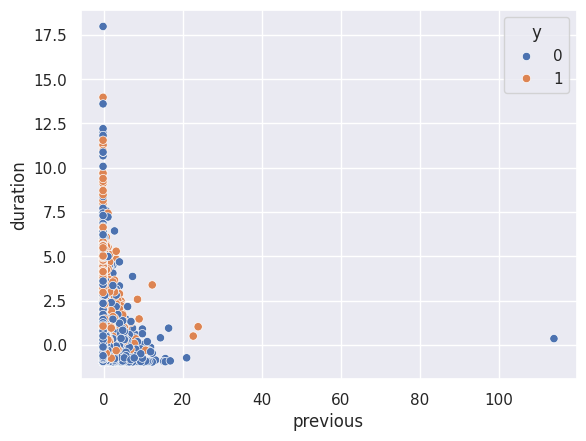

In [67]:
sns.scatterplot(x = x_train['previous'], y = x_train['duration'],hue = y_train) #Before SMOTE
plt.show()

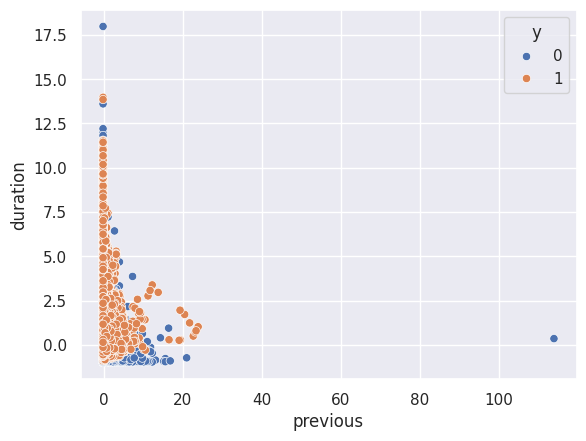

In [68]:
sns.scatterplot(x = x_train_smote['previous'], y = x_train_smote['duration'],hue = y_train_smote) #AFTER SMOTE
plt.show()

In [100]:
# Comparing all the models for a baseline prediction and selecting the best model
list_met = []
list_accuracy = []

#Logistic REgression
logit = LogisticRegression()
logit.fit(x_train_smote,y_train_smote)
y_pred_lr = logit.predict(x_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

#Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(x_train_smote,y_train_smote)
y_pred_dt = dtree.predict(x_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Random Fores
rforest = RandomForestClassifier()
rforest.fit(x_train_smote,y_train_smote)
y_pred_rf = rforest.predict(x_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

#XGBoost
xg = XGBClassifier()
xg.fit(x_train_smote,y_train_smote)
y_pred_xg = xg.predict(x_test)
accuracy_xg = accuracy_score(y_test, y_pred_xg)

# KNN
knn = KNeighborsClassifier()
knn.fit(x_train_smote,y_train_smote)
y_pred_knn = knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# SVM
svm = SVC()
svm.fit(x_train_smote,y_train_smote)
y_pred_svm = svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

#NaiveBayes Theorem
nb = GaussianNB()
nb.fit(x_train_smote,y_train_smote)
y_pred_nb = nb.predict(x_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Voting classifier
model_vc = VotingClassifier(estimators = [('logit',logit),('dtree',dtree),('rforest',rforest),
                                          ('knn',knn),('svm',svm),('nb',nb),('xgboost',xg)])
model_vc.fit(x_train_smote,y_train_smote)
y_pred_vc = model_vc.predict(x_test)
accuracy_vc = accuracy_score(y_test, y_pred_vc)

list1 = ['LogitRegession','Dtree','RForest','XGB','KNN','SVM','NBT','Voting']
list2 = [accuracy_lr,accuracy_dt,accuracy_rf,accuracy_xg,accuracy_knn,accuracy_svm,accuracy_nb,accuracy_vc]

df_accuracy = pd.DataFrame({'Model':list1,'Accuracy':list2})
print(df_accuracy)



            Model  Accuracy
0  LogitRegession  0.827159
1           Dtree  0.796307
2         RForest  0.828376
3             XGB  0.671016
4             KNN  0.831804
5             SVM  0.821298
6             NBT  0.741347
7          Voting  0.837222


Axes(0.125,0.11;0.775x0.77)


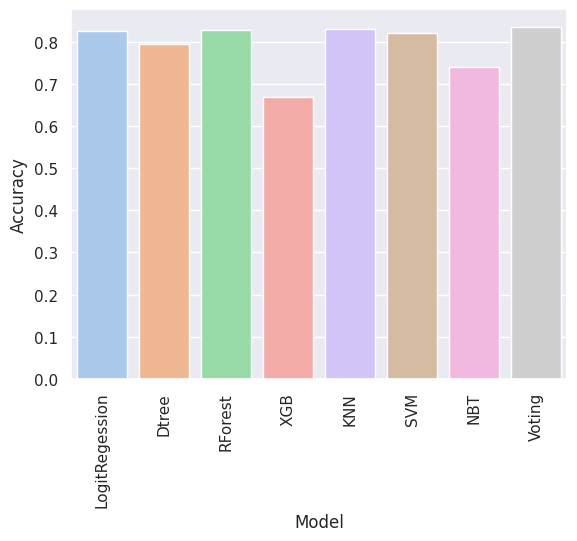

In [101]:
# Comparing the test accuracy of all the models with original columns and default parameters
chart = sns.barplot(x = 'Model',y = 'Accuracy', data = df_accuracy, palette= 'pastel')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)
print(chart)

In [ ]:
# exploring Randomforest as a potential model and to extract important features
from sklearn.model_selection import GridSearchCV
hyper_fit = GridSearchCV(rforest, cv=5,
                         param_grid = {'criterion': ['gini', 'entropy'],
                                       'bootstrap': [True, False],
                                       'max_features': ['sqrt', 'log2', None]},
                         n_jobs=-1)

hyper_fit.fit(x_train_smote,y_train_smote)
print('best parameters from grid search: ',hyper_fit.best_params_)

In [71]:
best_params ={'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2'}
#best parameters from grid search: {'bootstrap': False, 'criterion': 'gini', 'max_features': 'log2'}

In [72]:
final_rf_model = RandomForestClassifier(**best_params,random_state=42)


Training score:  100.0 %

Testing accuracy:  79.97 %
Classification Report 

               precision    recall  f1-score   support

           0       0.94      0.82      0.88      7985
           1       0.32      0.63      0.42      1058

    accuracy                           0.80      9043
   macro avg       0.63      0.73      0.65      9043
weighted avg       0.87      0.80      0.83      9043



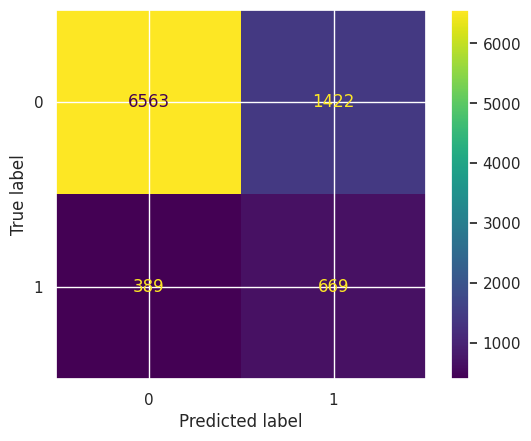

In [73]:
# Training and testing the RandomForestClassifier model with original features
final_rf_model.fit(x_train_smote,y_train_smote)
print('\nTraining score: ',round(final_rf_model.score(x_train_smote,y_train_smote)*100,2),'%')

y_pred = final_rf_model.predict(x_test)
print('\nTesting accuracy: ',round(accuracy_score(y_test,y_pred)*100,2),'%')
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
print('Classification Report \n\n',classification_report(y_test,y_pred))

In [74]:
# variable importance array
importance = final_rf_model.feature_importances_
importance = np.sort(importance)[::-1]
importance

array([0.30781504, 0.09354876, 0.07415977, 0.06892822, 0.06385358,
       0.05671588, 0.05662123, 0.04803517, 0.02895711, 0.02513184,
       0.02497664, 0.02067844, 0.01851005, 0.01284225, 0.01277013,
       0.01201163, 0.0118567 , 0.01147929, 0.00894365, 0.00805779,
       0.00551245, 0.00544905, 0.00467761, 0.00458881, 0.00422243,
       0.00420278, 0.00377582, 0.00167788])

In [75]:
indx = np.argsort(importance)[::-1]
indx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [76]:
# list of independent variables
name_indx=list(x_train.columns)
name_indx

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'default',
 'housing',
 'loan',
 'telephone',
 'blue-collar',
 'entrepreneur',
 'housemaid',
 'management',
 'retired',
 'self-employed',
 'services',
 'student',
 'technician',
 'unemployed',
 'married',
 'single',
 'other',
 'success',
 'unknown',
 'education',
 'month']

In [77]:
# dataframe for importance
impurity_df = pd.DataFrame({'mean_impurity':importance,'column_index':indx})
impurity_df.index = range(1,len(impurity_df)+1)
impurity_df['column_name'] = impurity_df['column_index'].apply(lambda x:name_indx[x])
impurity_df = impurity_df[['column_name','mean_impurity']]
impurity_df['percentage_impurity'] = round(impurity_df['mean_impurity']*100,3)
impurity_df['cum_impurity'] = impurity_df['percentage_impurity'].cumsum()
impurity_df

,column_name,mean_impurity,percentage_impurity,cum_impurity
1,age,0.307815,30.782,30.782
2,balance,0.093549,9.355,40.137
3,day,0.074160,7.416,47.553
4,duration,0.068928,6.893,54.446
5,campaign,0.063854,6.385,60.831
6,pdays,0.056716,5.672,66.503
7,previous,0.056621,5.662,72.165
8,default,0.048035,4.804,76.969
9,housing,0.028957,2.896,79.865
10,loan,0.025132,2.513,82.378


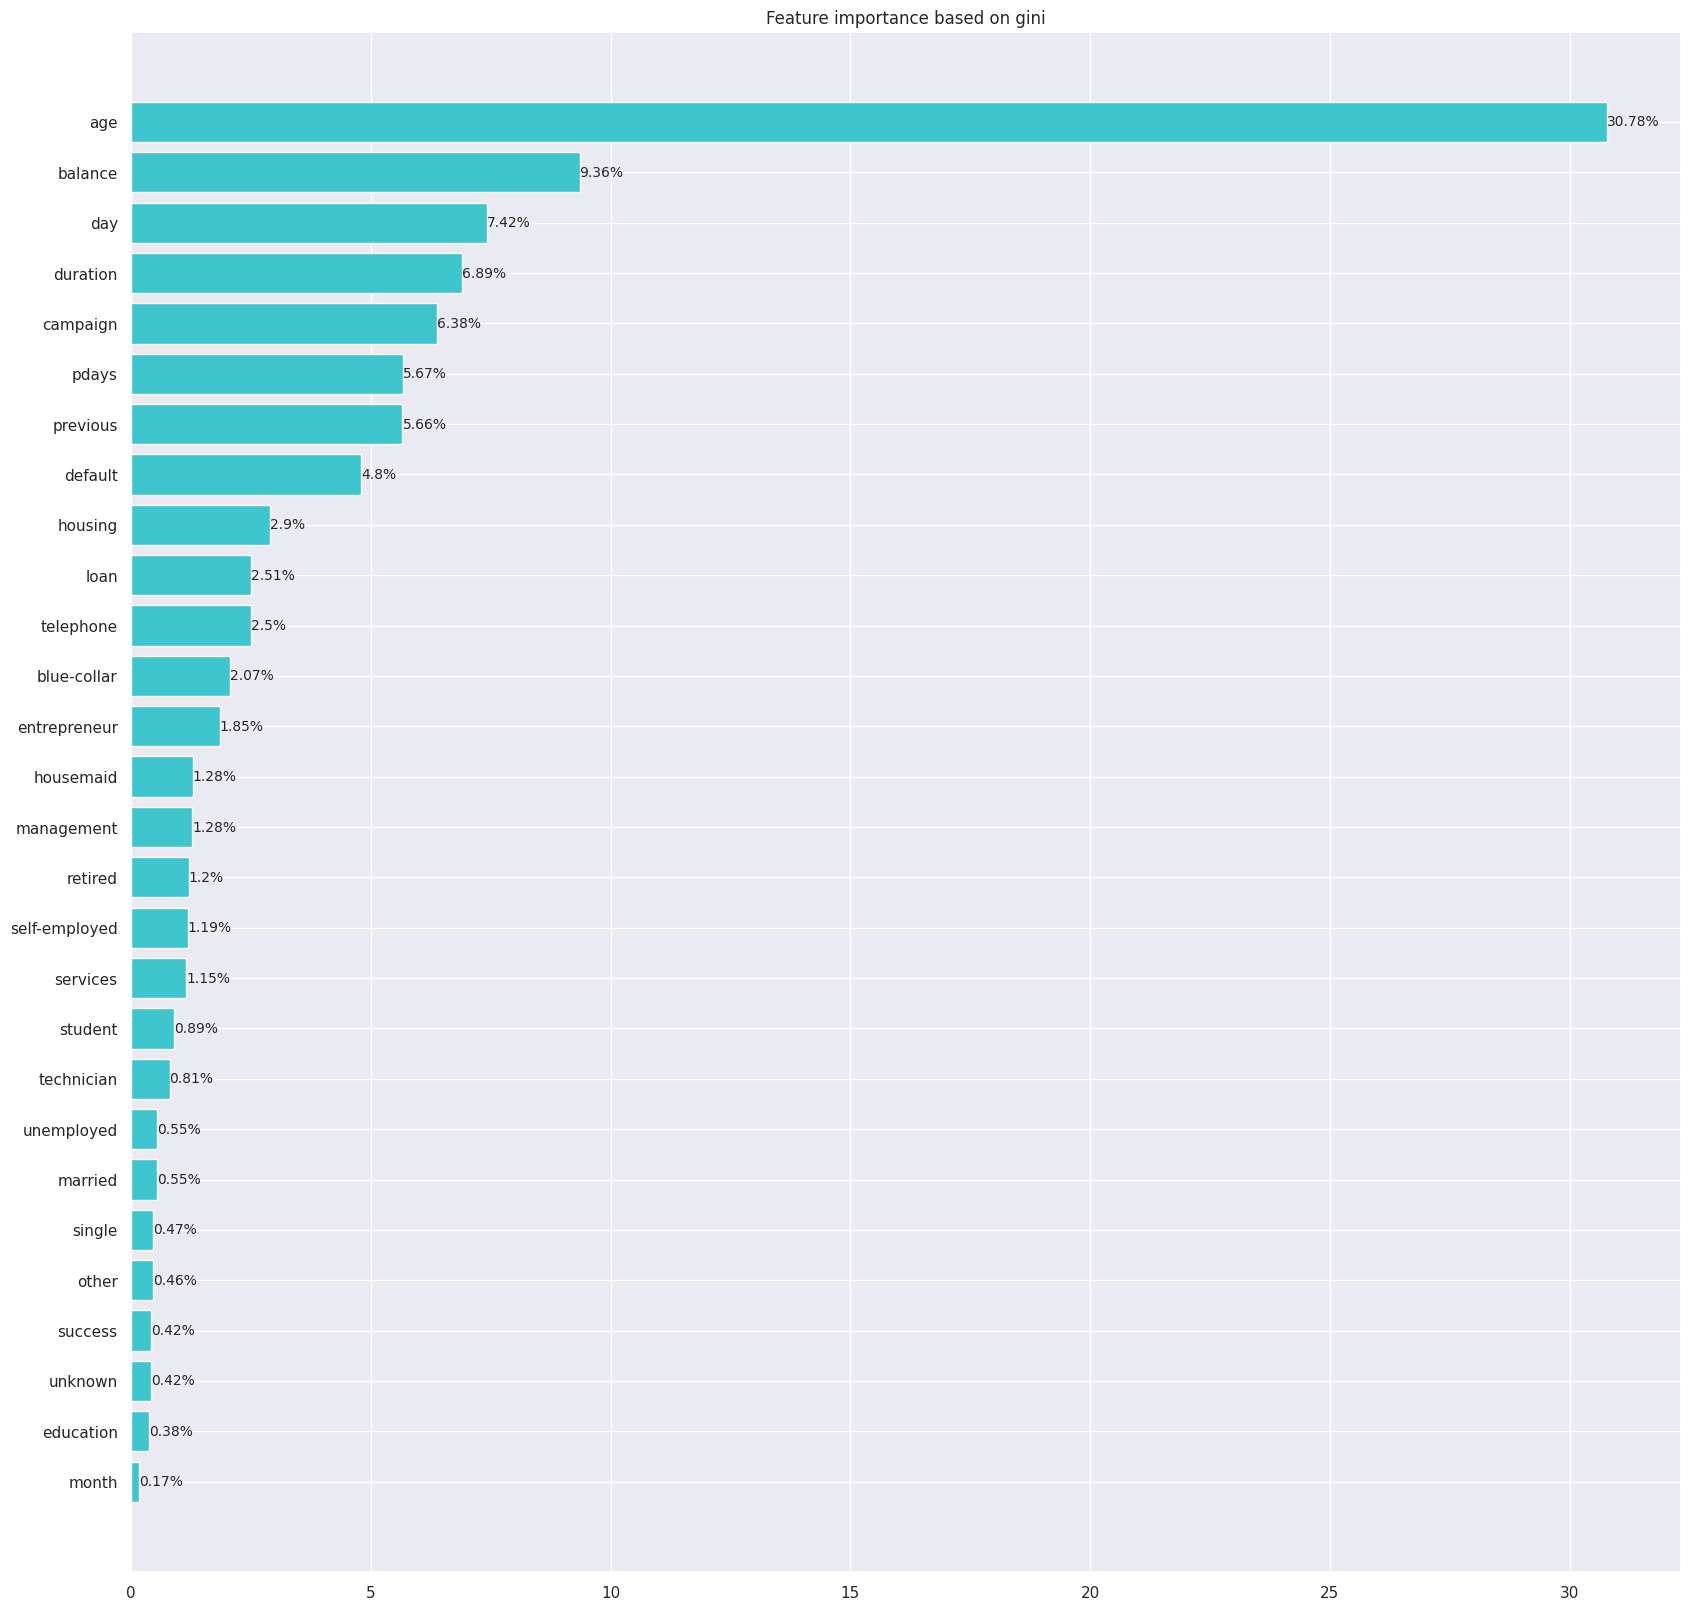

In [78]:
#feature importance graph
fig,ax = plt.subplots(figsize = (20,20))
plt.title('Feature importance based on gini')
plt.barh('column_name','percentage_impurity',data = impurity_df,align='center',color = '#3EC5CD')
for i, val in enumerate(impurity_df['percentage_impurity']):
    plt.text(val,i,f'{round(val,2)}%',va = 'center',fontsize = 10)
plt.gca().invert_yaxis()
plt.show()

In [79]:
# filtering the columns with 90% mean impurity
final_cols = list(impurity_df[impurity_df['cum_impurity']<=90].column_name)

x_train_filtered = x_train_smote[final_cols]
x_test_filtered = x_test[final_cols]

In [81]:
y_train_smote.value_counts()

,count
y,
0,31937
1,31937


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



Training Score: 1.0

Testing Accuracy:  69.34 %

Classification Report:                precision    recall  f1-score   support

           0       0.95      0.69      0.80      7985
           1       0.23      0.70      0.35      1058

    accuracy                           0.69      9043
   macro avg       0.59      0.70      0.57      9043
weighted avg       0.86      0.69      0.75      9043



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


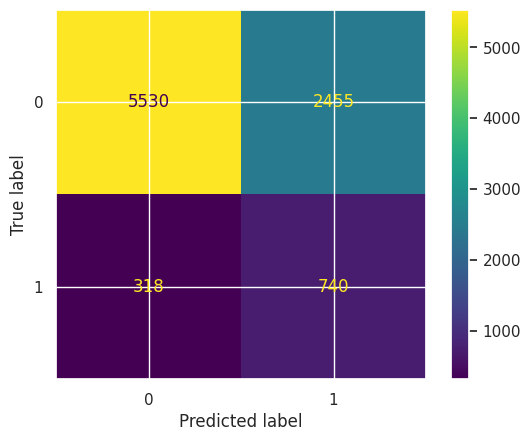

In [82]:
# Training and testing the Random Forest classifier with best parameters
final_params = final_rf_model.get_params()
opt_model = RandomForestClassifier(**final_params)
opt_model.set_params(verbose = 1)

opt_model.fit(x_train_filtered,y_train_smote)

print('\nTraining Score:',opt_model.score(x_train_filtered,y_train_smote))

opt_y_pred = opt_model.predict(x_test_filtered)

print('\nTesting Accuracy: ',round(accuracy_score(y_test,opt_y_pred)*100,2),'%')
cm = ConfusionMatrixDisplay.from_predictions(y_test,opt_y_pred)
print('\nClassification Report: ',classification_report(y_test,opt_y_pred))

In [83]:
x_train_filtered

,age,balance,day,duration,campaign,pdays,previous,default,housing,loan,telephone,blue-collar,entrepreneur
0,-0.460434,-0.164410,1.582124,-0.457311,-0.246104,-0.410910,-0.241509,0.0,0.000000,0.000000,1.0,0.0,0.0
1,-1.589641,0.899627,-1.298384,2.502493,0.398202,1.446096,2.664584,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.292371,-0.365486,-0.458236,5.697691,0.398202,-0.410910,-0.241509,0.0,1.000000,0.000000,0.0,0.0,0.0
3,0.668773,-0.445003,1.822166,-0.862499,2.653271,-0.410910,-0.241509,0.0,0.000000,0.000000,1.0,0.0,0.0
4,-0.272233,-0.361249,1.222060,-0.777602,2.331118,-0.410910,-0.241509,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63869,-0.559339,-0.264884,0.757295,1.160191,-0.254328,-0.410910,-0.241509,0.0,0.974472,0.000000,0.0,0.0,0.0
63870,-0.796584,-0.266465,-0.346545,-0.181184,-0.499354,0.478350,0.677598,0.0,1.000000,0.786119,0.0,0.0,0.0
63871,0.665305,0.650135,1.702145,0.297182,-0.012603,-0.410910,-0.241509,0.0,0.000000,0.000000,0.0,0.0,0.0
63872,2.536858,0.027567,-0.896416,-0.144759,-0.568256,-0.410910,-0.241509,0.0,0.000000,0.000000,0.0,0.0,0.0


In [86]:
# Hyperparameter tuning the LogisticRegression model
final_lr_model = LogisticRegression(random_state=42)
lr_hyper_fit = GridSearchCV(final_lr_model,param_grid = {
    'penalty':['l1','l2','elasticnet'],
    'C':[0.1,1,10],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[100,500,1000]

}
                            ,n_jobs = -1)
lr_hyper_fit.fit(x_train_filtered,y_train_smote)
print('best parameters from grid search: ',lr_hyper_fit.best_params_)

best parameters from grid search:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


In [95]:
# Initializing the LogisticRegression model with best parameters
best_params = {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
final_lr = LogisticRegression(**best_params,random_state = 42)


Training Score:  79.9 %

Testing Accuracy:  80.12 %


Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.80      0.88      7985
           1       0.35      0.78      0.48      1058

    accuracy                           0.80      9043
   macro avg       0.66      0.79      0.68      9043
weighted avg       0.89      0.80      0.83      9043



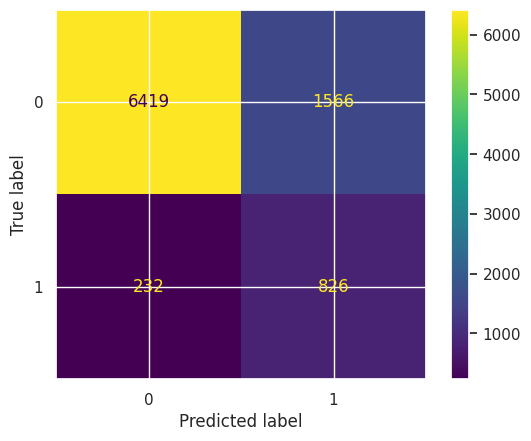

In [112]:
# Training and testing the Logistic Regression model with best Parameters
final_lr.fit(x_train_filtered, y_train_smote)
print('Training Score: ',round(final_lr.score(x_train_filtered,y_train_smote)*100,2),'%')
y_lr_pred = final_lr.predict(x_test_filtered)
print('\nTesting Accuracy: ',round(accuracy_score(y_test,y_lr_pred)*100,2),'%')
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_lr_pred)
print('\n\nClassification Report: \n\n',classification_report(y_test,y_lr_pred))

In [111]:
auc_roc = round(roc_auc_score(y_test,y_lr_pred)*100,2)
print('AUC-ROC score: ',auc_roc)

AUC-ROC score:  79.23


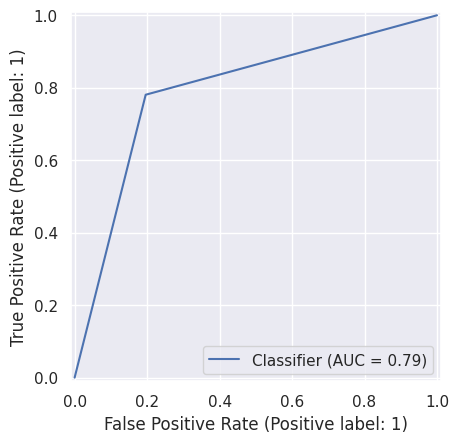

In [113]:
RocCurveDisplay.from_predictions(y_test,y_lr_pred)
plt.show()

In [116]:
#Hyperparameter tuning the knn classifier
knn = KNeighborsClassifier()
knn_hyper_fit = GridSearchCV(knn,cv = 5, param_grid = {'n_neighbors':[2,3,5],
                                                       'weights':['uniform','distance'],
                                                       'algorithm':['ball_tree','kd_tree','brute']},
                             )
knn_hyper_fit.fit(x_train_filtered,y_train_smote)
print('best parameters from grid search: ',knn_hyper_fit.best_params_)

Training Accuracy:  92.39 %

Testing Accuracy:  81.09 %


Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.82      0.89      7985
           1       0.35      0.71      0.47      1058

    accuracy                           0.81      9043
   macro avg       0.65      0.77      0.68      9043
weighted avg       0.88      0.81      0.84      9043



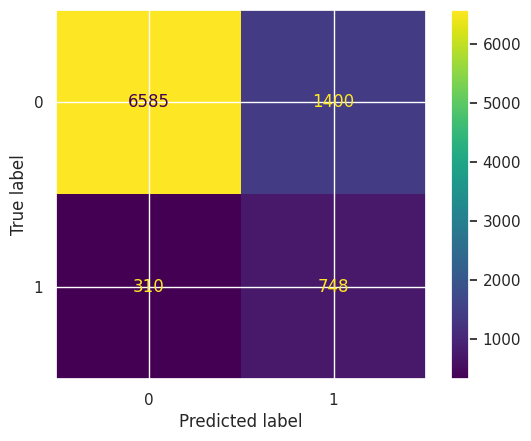

In [102]:
#Training the knn classifier with best parameters
knn_hyper_fit_bestparams = knn_hyper_fit.best_params_
knn = KNeighborsClassifier(knn_hyper_fit_bestparams)
knn.fit(x_train_filtered,y_train_smote)
y_pred_knn = knn.predict(x_test_filtered)
print('Training Accuracy: ',round(knn.score(x_train_filtered,y_train_smote)*100,2),'%')
print('\nTesting Accuracy: ',round(accuracy_score(y_test,y_pred_knn)*100,2),'%')
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_knn)
print('\n\nClassification Report: \n\n',classification_report(y_test,y_pred_knn))

In [114]:
auc_roc = round(roc_auc_score(y_test,y_pred_knn)*100,2)
print('AUC-ROC score: ',auc_roc)

AUC-ROC score:  76.58


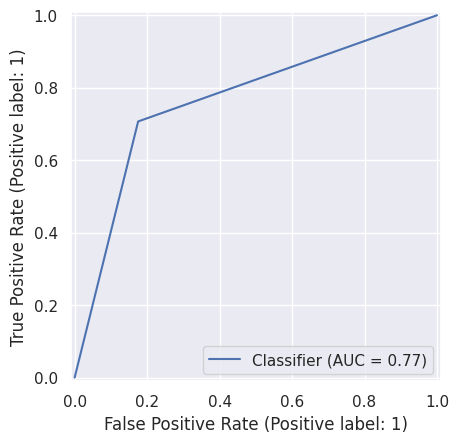

In [108]:
RocCurveDisplay.from_predictions(y_test,y_pred_knn)
plt.show()

Training score:  95.15 %

Testing Accuracy:  75.92 %


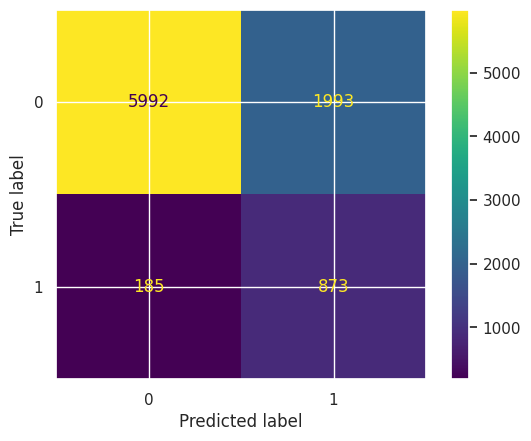

In [104]:
#Testing the Voting Classifier with the filtered data set
model_vc2 = VotingClassifier(estimators = [('logit',final_lr),('dtree',dtree),('rforest',final_rf_model),
                                          ('knn',knn),('svm',svm),('nb',nb),('xgboost',xg)])
model_vc2.fit(x_train_filtered,y_train_smote)
y_pred_vc = model_vc2.predict(x_test_filtered)
print('Training score: ',round(model_vc2.score(x_train_filtered,y_train_smote)*100,2),'%')
print()
print('Testing Accuracy: ',round(accuracy_score(y_test,y_pred_vc)*100,2),'%')
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_vc)

In [115]:
auc_roc = round(roc_auc_score(y_test,y_pred_vc)*100,2)
print('AUC-ROC score: ',auc_roc)

AUC-ROC score:  78.78


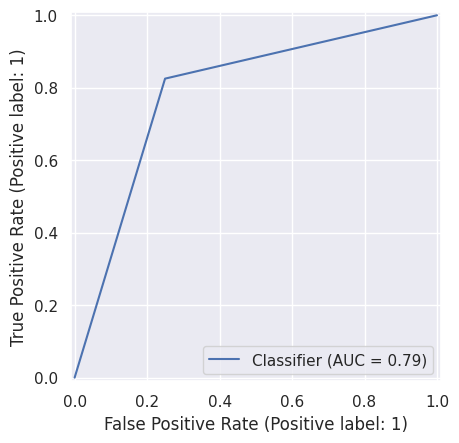

In [107]:
RocCurveDisplay.from_predictions(y_test,y_pred_vc)
plt.show()

##Thus after after testing the above models we can conclude that Logistic Regression model gives the best consitent results.
##Training Score = 79%
##Testing Score = 80%
##roc_auc score = 79.23

In [123]:
# Testing the model with manual input
def predict(test_data):
  y_pred = final_lr.predict(test_data)
  if y_pred == 0:
    print('No, The customer is not likely to buy a term deposit')
  else:
    print('Yes, The customer is likely to buy a term deposit')


In [130]:
predict([[25,50000,13,20,2,-1,9,1,0,0,1,1,0]])

Yes, The customer is likely to buy a term deposit
